In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings
from scipy.ndimage.measurements import label

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [55]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/rollingCorr/GRIDSAT_u200_rollingCorr_SouthAmerica_1995.nc')
corr_end = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/rollingCorr/GRIDSAT_u200_rollingCorr_SouthAmerica_2006.nc')

In [56]:
corr_all = corr_all.assign_coords(time=corr_all['time.dayofyear'].values)
corr_end = corr_end.assign_coords(time=corr_end['time.dayofyear'].values)

In [57]:
corr_all

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 365)
Coordinates:
    level      int32 ...
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * time       (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    pval       (time, latitude, longitude) float64 ...
    r          (time, latitude, longitude) float64 ...
    slope      (time, latitude, longitude) float64 ...

In [63]:
corr = corr_all.sel(time=(corr_all.time>182))

In [64]:
corr

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 183)
Coordinates:
    level      int32 ...
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * time       (time) int64 183 184 185 186 187 188 ... 360 361 362 363 364 365
Data variables:
    pval       (time, latitude, longitude) float64 ...
    r          (time, latitude, longitude) float64 ...
    slope      (time, latitude, longitude) float64 ...

In [65]:
corr_sig = corr.where(corr['pval']<=0.05)

In [66]:
array = corr_sig['r'].values

In [67]:
array.shape

(183, 125, 97)

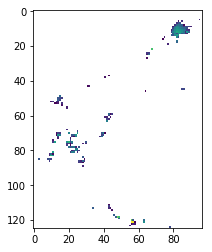

In [68]:
plt.imshow(array[100,:,:])

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


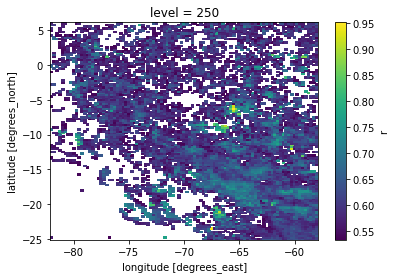

In [69]:
corr_sig['r'].where(corr_all['pval']<=0.05).mean('time').plot()

In [70]:
ts = array[:,58,21]

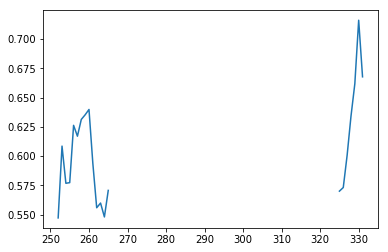

In [71]:
plt.plot(corr_sig.time.values, ts)

In [72]:
thresh = 0.2
ts[ts <= thresh] = 0  # T threshold maskout
ts[np.isnan(ts)] = 0  # set ocean nans to 0
labels, numL = label(ts)

(174.9, 375.1)

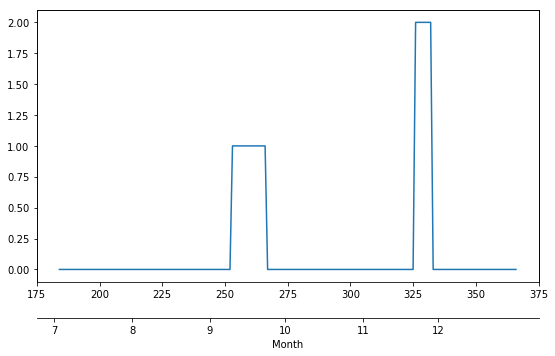

In [73]:
f = plt.figure(figsize=(9,5))
ax = f.add_subplot(111)
ax.plot(corr_sig.time+1, labels)
mdays = [1,32,60,91,121,152,182,213,244,274,305,335]
ax1 = ax.twiny()
ax1.set_xticks(mdays)
ax1.set_xticklabels(np.arange(1,13))
ax1.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax1.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax1.spines['bottom'].set_position(('outward', 36))
ax1.set_xlabel('Month')
ax1.set_xlim(ax.get_xlim())


In [74]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.time>gt_doy
        pindex = 0
        rcheck = -60
    if lt_doy is not None:
        mask = corr_all.time<lt_doy
        pindex = -1
        rcheck = 60
        
    corr = corr_all.sel(time=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = 0.1
    array[array <= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=2)&(u!=0)]
            inds_5 = u[(n>=5)&(u!=0)]
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.time.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.time.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)>=40):
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)>=40):
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5

    return outarr_3, outarr_5

In [75]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=182)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [76]:
outarr_3end, outarr_5end = find_doy(corr_end, gt_doy=182)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [77]:
endarr_3, endarr_5 = find_doy(corr_all, lt_doy=182)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [78]:
endarr_3end, endarr_5end = find_doy(corr_end, lt_doy=182)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [79]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-83,-55), lat=slice(-26,7))
topo_on_g = corr_all.salem.lookup_transform(topo)

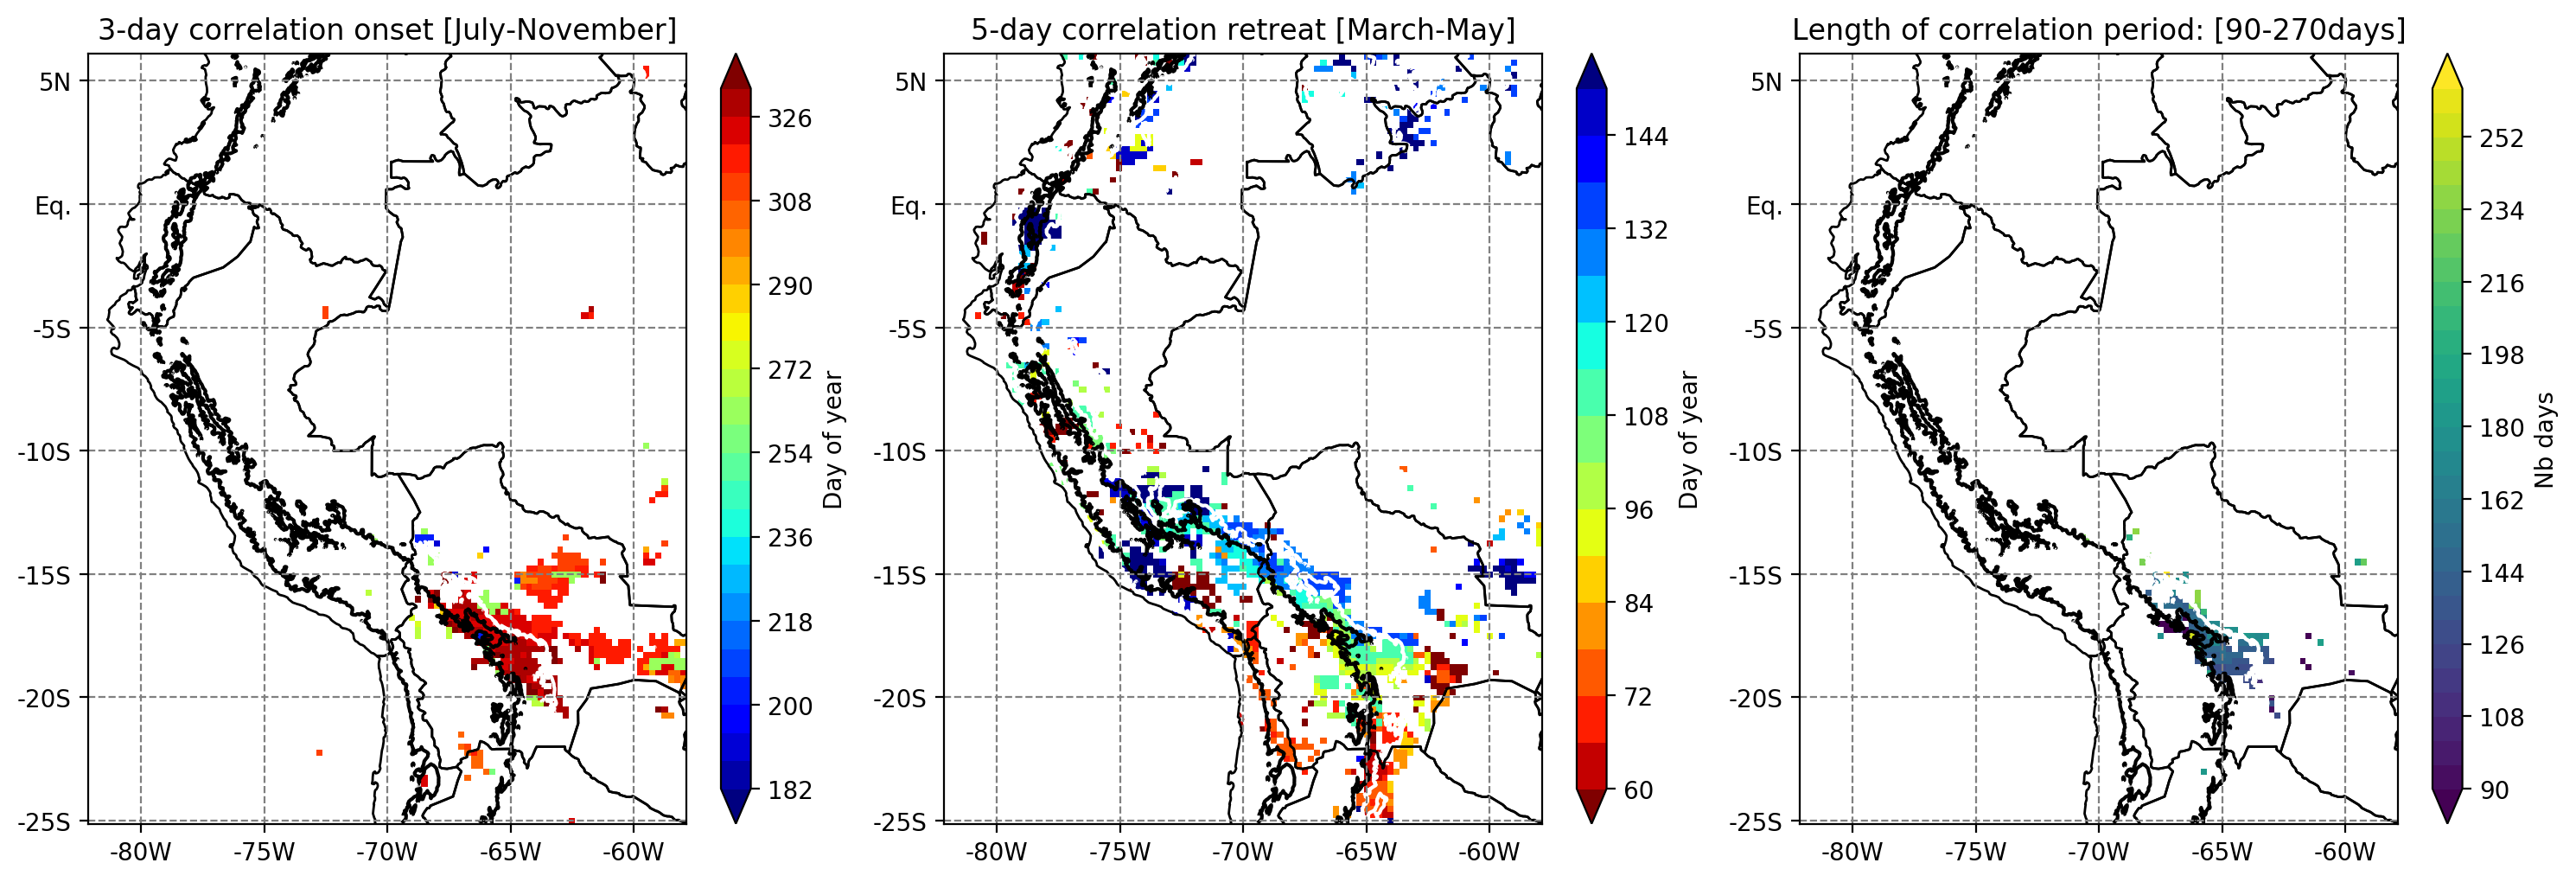

In [80]:
map = corr_all.salem.get_map()
f = plt.figure(figsize=(15,5.5), dpi=200)

ax = f.add_subplot(131)

map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(132)
endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(133)
endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3)+endarr_5)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200_CCT_correlation_1984-2019.png')

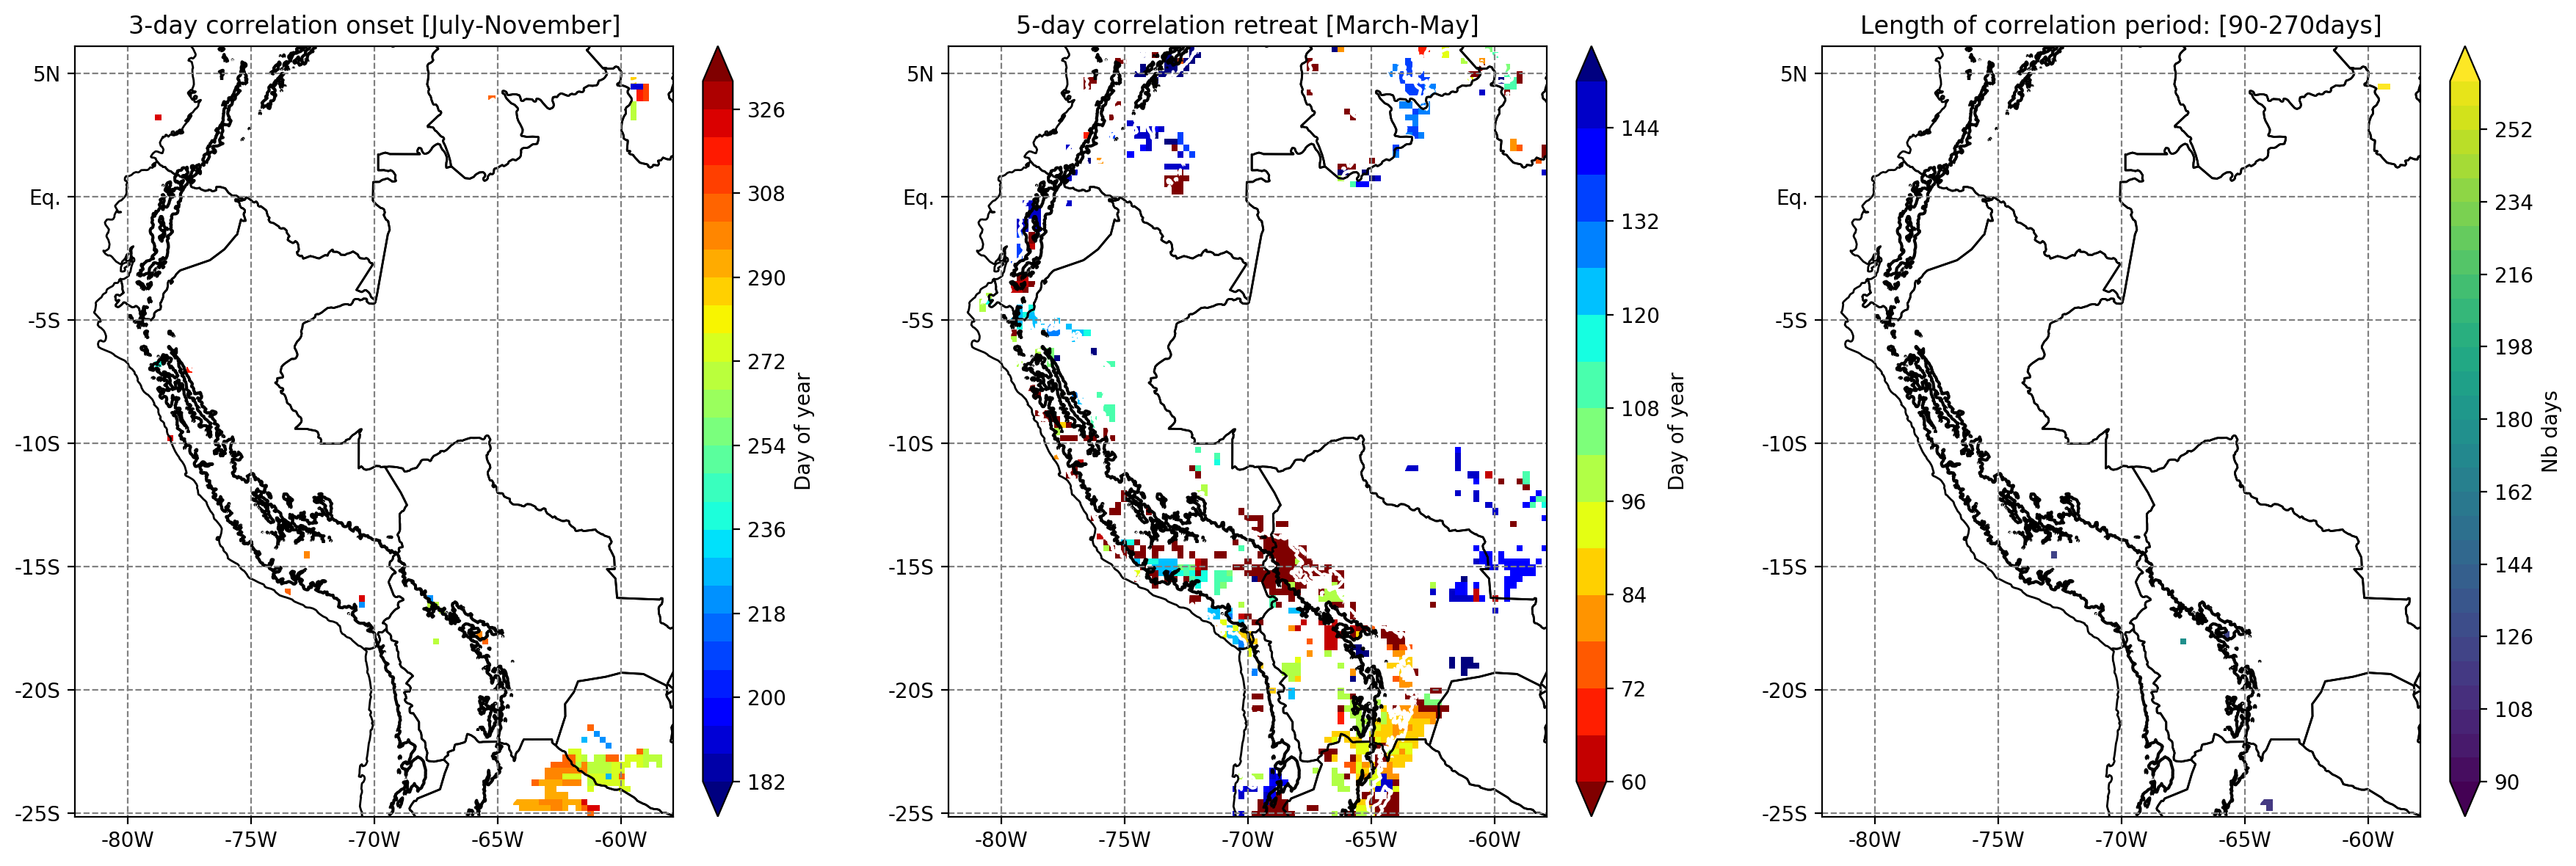

In [81]:
map = corr_all.salem.get_map()
f = plt.figure(figsize=(18,6), dpi=200)

ax = f.add_subplot(131)

map.set_data(outarr_3end)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(132)
endarr_5end[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5end)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(133)
endarr_5end[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3end)+endarr_5end)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200_CCT_correlation_2000-2019.png')

In [311]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.5)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))
y = int(pickpos[0])
x = int(pickpos[1])
date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(outarr_3[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz onset', outarr_3[y,x], 'Date', dstr)
date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(endarr_5[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz retreat', endarr_5[y,x], 'Date', dstr)

Huaraz onset 267.0 Date 24/09
Huaraz retreat 112.0 Date 22/04
